In [16]:
import pandas as pd
import numpy as np

from clustering_functions import *
from impute_transform import ImputeTransform
from fancyimpute import MICE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('seaborn-paper')

# Unsupervised Learning in ADHD

## Introduction

## Overview of Methods

## Overview of Results (?)

---

# TMCQ Cluster Analysis

## Prepare Data

Participants with any null TMCQ values are dropped.

In [3]:
data = pd.read_csv('data/full_data.csv')
#small_data = data.sample(n=200)
TMCQ_all, TMCQ_adhd, TMCQ_control = prep_data(data, dataset='TMCQ')

In [3]:
print_ns(TMCQ_all, TMCQ_adhd, TMCQ_control)

Ns for each group
-----------------
All:      888
ADHD:     564
Control:  324


## Choose K for each group

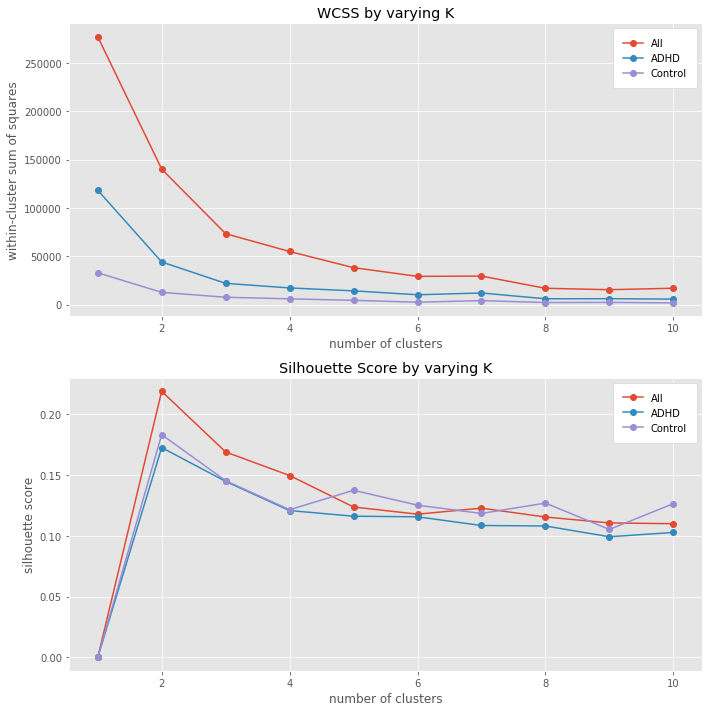

In [7]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
km = KMeans(n_jobs=-1)
wcss_and_silhouette(TMCQ_all, km, axs, 'All')
wcss_and_silhouette(TMCQ_adhd, km, axs, 'ADHD')
wcss_and_silhouette(TMCQ_control, km, axs, 'Control')
plt.tight_layout()

2 seems to be the best number of clusters for all groups.

## Group = All, K = 2

What kind of insights can we gain from the KMeans Cluster Analysis on the TMCQ dataset with all subjects?

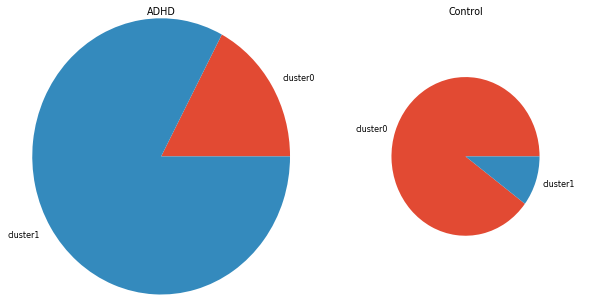

In [17]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
build_piechart(TMCQ_all, data, km, 'DX', axs)

Here we can see that Cluster 0 roughly corresponds to Control, and Cluster 1 roughly corresponds to ADHD.

Radius of the pie chart is: (N of the diagnosis group / total N) * 2

Below is proportions of clusters per DX group for DXSUB.

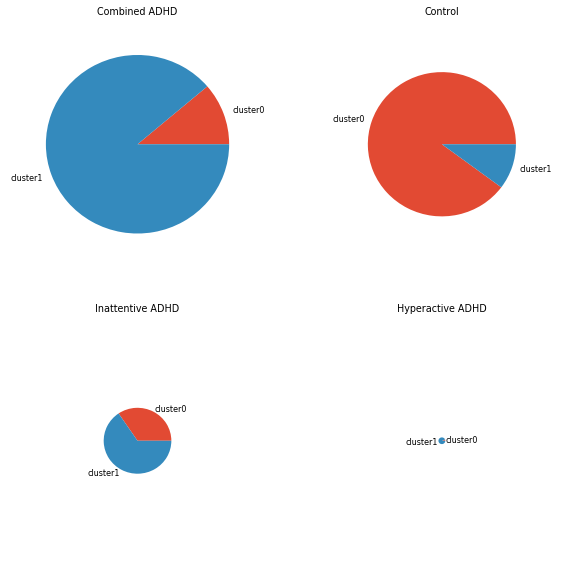

In [18]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
build_piechart(TMCQ_all, data, km, 'DXSUB', axs.flatten(),
               title_dict = {1.0: 'Control', 3.0:
                             'Inattentive ADHD', 4.0: 'Hyperactive ADHD', 5.0: 'Combined ADHD'})

This is a little less informative (particularly for Inattentive and Hyperactive ADHD because of their low Ns). However we see the same pattern of Cluster 1 corresponding to ADHD subtypes.

## Group = ADHD, Control, K = 2

We will now examine the TMCQ scores. We split the TMCQ dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean TMCQ scores in each cluster between the groups.

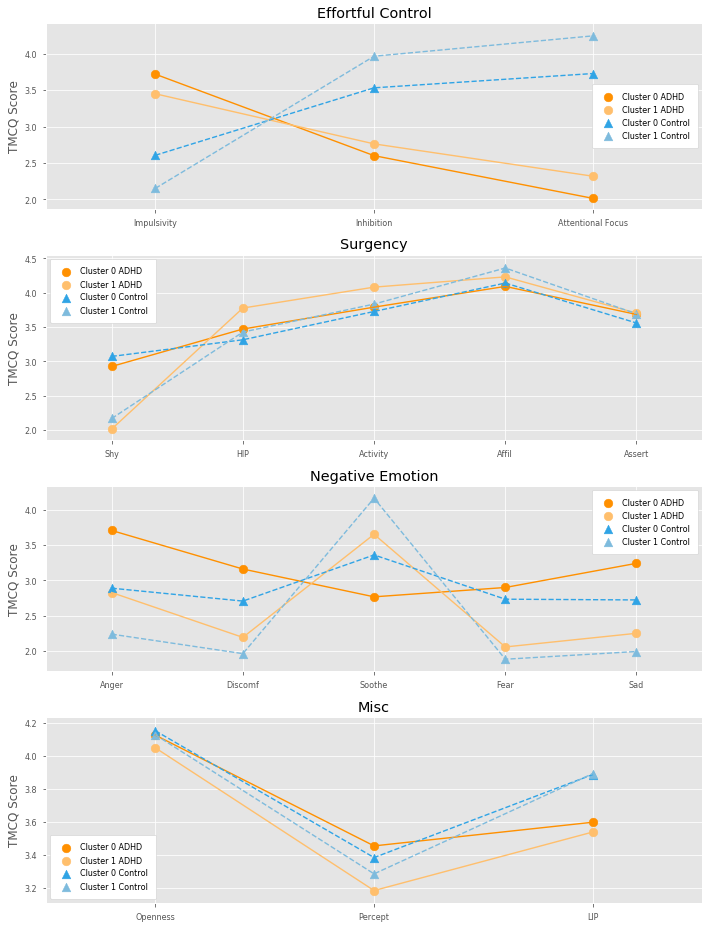

In [29]:
km = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
fig, axs = plt.subplots(4,1,figsize=(10,13))
run_ADHD_Control_k2(TMCQ_adhd, TMCQ_control, km, axs)
plt.tight_layout()

## Statistical Tests
We will now examine the TMCQ scores. We split the TMCQ dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean TMCQ scores in each cluster between the groups.

---

# Neuropsych Cluster Analysis

## Prepare Data

Subjects with _all_ null neuropsych values are dropped. Imputation for missing values will be done using the library fancy_impute's MICE()

In [41]:
data = pd.read_csv('data/full_data.csv')
#small_data = data.sample(n=200)
neuro_all, neuro_adhd, neuro_control = prep_data(data, dataset='neuro')

In [34]:
print_ns(neuro_all, neuro_adhd, neuro_control)

Ns for each group
-----------------
All:      651
ADHD:     394
Control:  257


## Choose K for each group

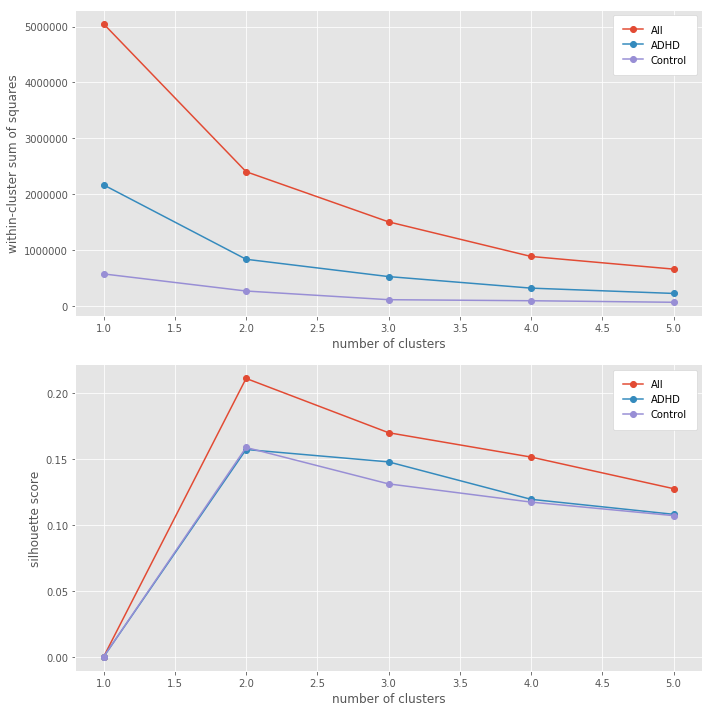

In [151]:
fig, axs = plt.subplots(2,1,figsize=(10,10))

scaler = StandardScaler()
kmeans = KMeans(n_jobs=-1, random_state=56)
steps = [('standard_scaler', scaler),
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

wcss_and_silhouette(TMCQ_all, pipeline, axs, 'All', standard_scale=True)
wcss_and_silhouette(TMCQ_adhd, pipeline, axs, 'ADHD', standard_scale=True)
wcss_and_silhouette(TMCQ_control, pipeline, axs, 'Control', standard_scale=True)
plt.tight_layout()

Again, 2 seems to be the best number of clusters for all groups.

## Group = All, K = 2

What kind of insights can we gain from the KMeans Cluster Analysis on the neuro dataset with all subjects?

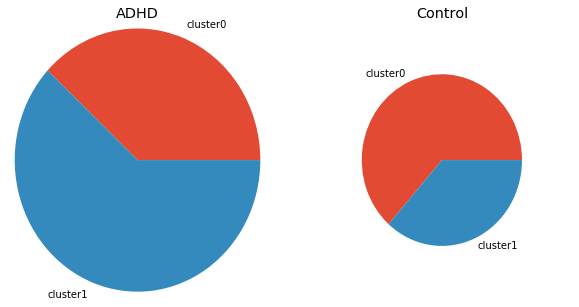

In [152]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

scaler = StandardScaler()
kmeans = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
steps = [('standard_scaler', scaler),
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

build_piechart(neuro_all, data, pipeline, 'DX', axs)

Here we can see that Cluster 0 roughly corresponds to Control, and Cluster 1 roughly corresponds to ADHD.

Radius of the pie chart is: (N of the diagnosis group / total N) * 2

Below is proportions of clusters per DX group for DXSUB.

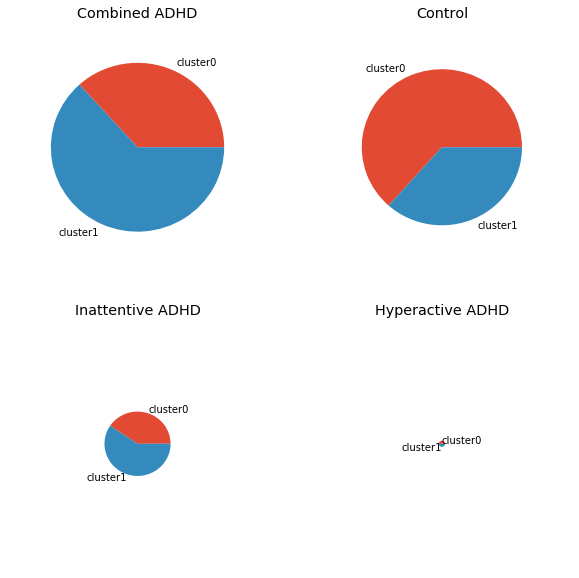

In [153]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
build_piechart(neuro_all, data, pipeline, 'DXSUB', axs.flatten(),
               title_dict = {1.0: 'Control', 3.0: 'Inattentive ADHD', 4.0: 'Hyperactive ADHD', 5.0: 'Combined ADHD'})

This is a little less informative (particularly for Inattentive and Hyperactive ADHD because of their low Ns). However we see the same pattern of Cluster 1 corresponding to ADHD subtypes.

## Group = ADHD, Control, K = 2

We will now examine the neuro scores. We split the neuro dataset into ADHD and Control groups. On each group, we run KMeans(n_clusters=2). We then compare mean neuro scores in each cluster between the groups.

In [50]:
data = pd.read_csv('data/full_data.csv')
neuro_all, neuro_adhd, neuro_control = prep_data(data, dataset='neuro', scale='before')

neuro_all_ns, neuro_adhd_ns, neuro_control_ns = prep_data(data, dataset='neuro')

(257, 16)
(257, 16)


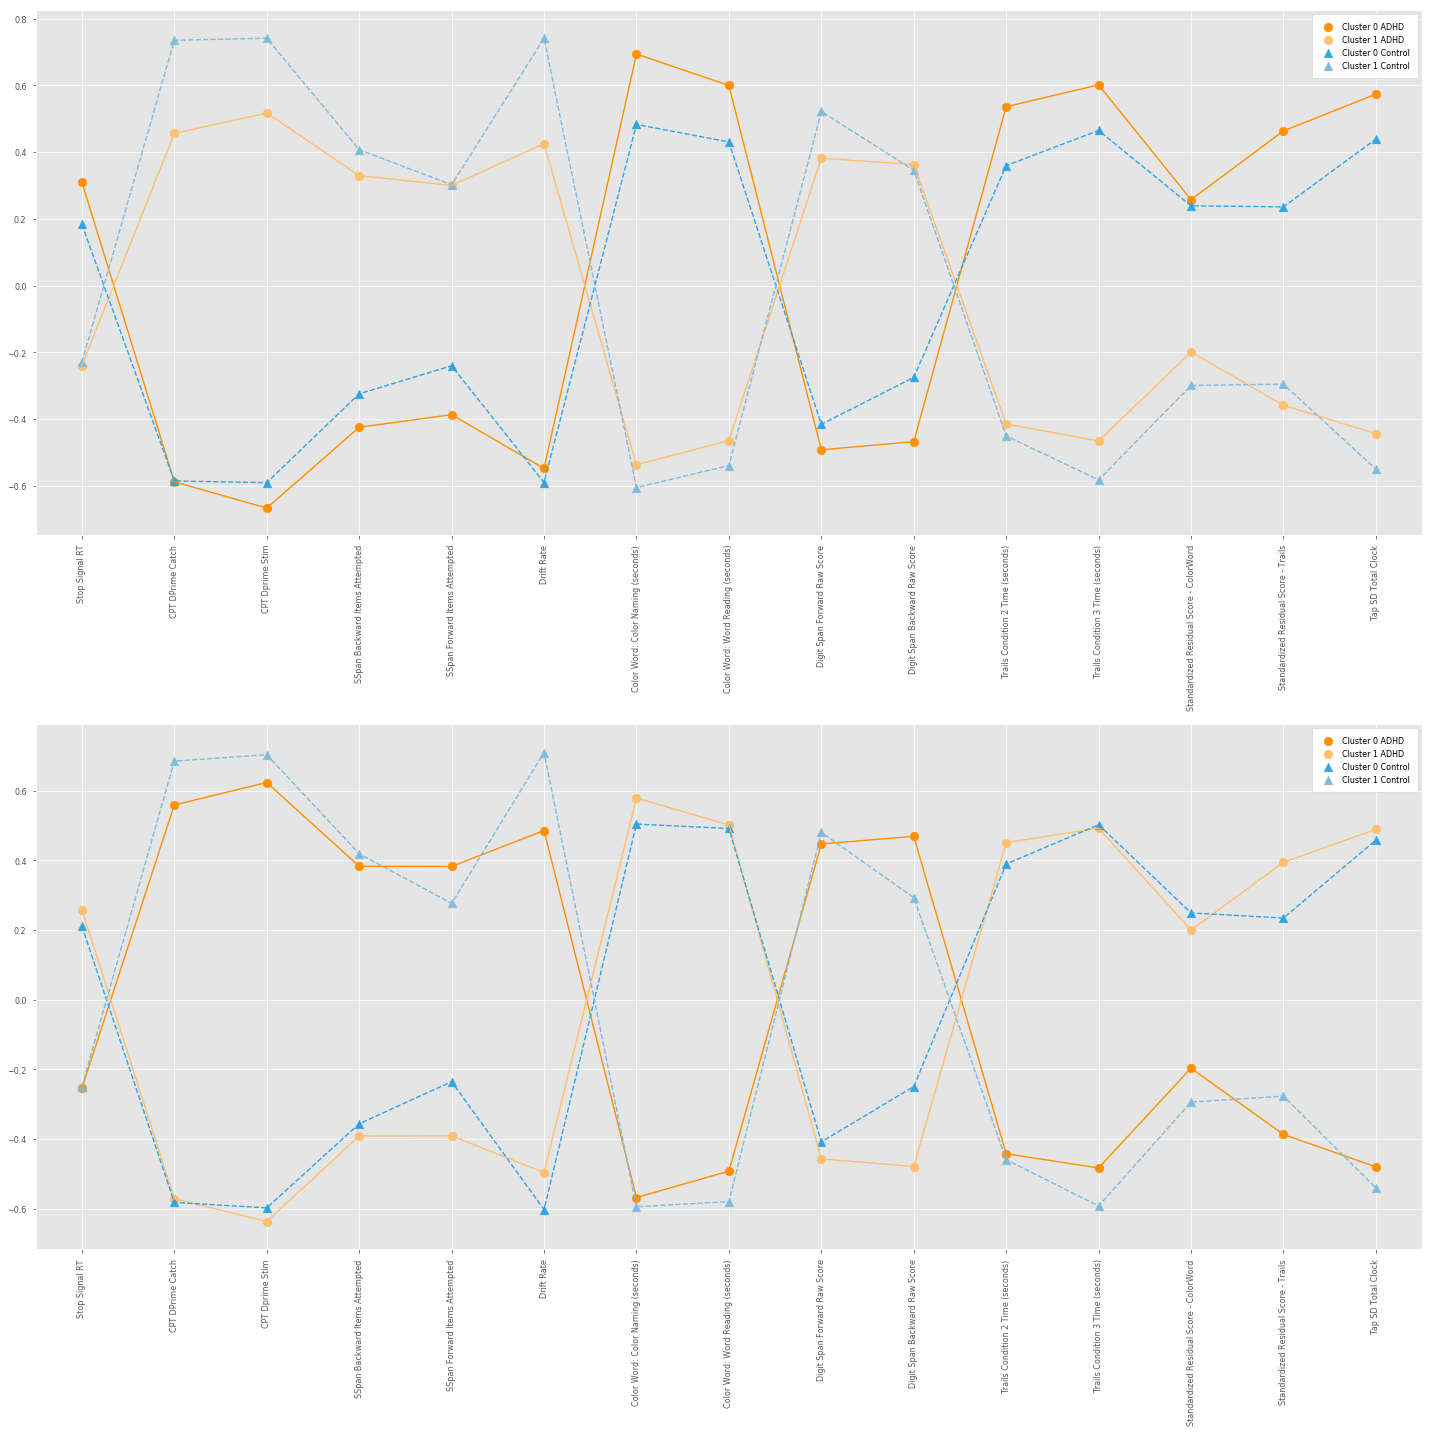

In [68]:
fig, axs = plt.subplots(2,1,figsize=(20,20))

scaler = StandardScaler()
kmeans = KMeans(n_clusters=2, n_jobs=-1, random_state=56)
steps = [('standard_scaler', scaler),
         ('kmeans', kmeans)]
pipeline = Pipeline(steps)

run_ADHD_Control_k2_neuro(neuro_adhd, neuro_control, kmeans, axs[0])
run_ADHD_Control_k2_neuro(neuro_adhd_ns, neuro_control_ns, pipeline, axs[1])
plt.tight_layout()

Statistical tests go here

---